# **WRF Spatial Map Plot for SWEX IOP 10**
## This notebook performs the following tasks:
> - #### Plots WRF variables (10m wind and 2m derived dewpoint) on a multi-panel map during various timepoins during SWEX IOP 10.

## **Package Imports**
### Links to package documentation and other notes
> - #### [pathlib](https://docs.python.org/3/library/pathlib.html) | [xwrf](https://xwrf.readthedocs.io/en/latest/) | [numpy](https://numpy.org/doc/1.21/) | [pandas](https://pandas.pydata.org/docs/) | [xarray](https://docs.xarray.dev/en/stable/) | [metpy](https://unidata.github.io/MetPy/latest/index.html) | [cartopy](https://scitools.org.uk/cartopy/docs/latest/) | [matplotlib](https://matplotlib.org/3.5.3/index.html)
> - #### Documentation for packages linked above should mostly correspond to the most stable versions, which may not be the exact versions used when creating this notebook.
> - #### Comments are also included in the actual code cells. Some comments contain links that point to places where I copied or adapted code to fit my needs. Although I tried to these include links for all instancs of copying, it is possible that there may code snippets that I did not do this for.

In [1]:
#-----------------------------------------------------
#entire package imports
import xwrf
import pathlib
import numpy as np
import pandas as pd
import xarray as xr

#metpy imports
import metpy.calc as mpcalc
from metpy.units import units

#cartopy imports
import cartopy.crs as ccrs

#matplotlib imports
import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#mapping function notebook
%run ./functions_swex_iop_10.ipynb
#-----------------------------------------------------

ERROR 1: PROJ: proj_create_from_database: Open of /home/sbarc/students/mariandob/mambaforge/envs/swex/share/proj failed


## **Define variables that point to paths for relevant data**
### Data Information
> - #### WRF Output Data: See associated manuscript for details. 

In [2]:
#-----------------------------------------------------
#Default run files
glob_wrf_domain_03_files = sorted(pathlib.Path('/home/voyager-sbarc/wrf/wrf460/sundowners/swex2022/iop10/run_1km_545_24_z107_2way/').glob('wrfout_d03*'))

#Display a glob variables to make sure we have files
display(glob_wrf_domain_03_files)
#-----------------------------------------------------

[PosixPath('/home/voyager-sbarc/wrf/wrf460/sundowners/swex2022/iop10/run_1km_545_24_z107_2way/wrfout_d03_2022-05-11_18:00:00')]

## **Read in WRF output NetCDF files using xarray and postprocess them using xwrf**
### Notes
> - #### Depending on the spatial and temporal resolution of the file being loaded, this may take some time to run.
> - #### See inline comments for additional details.

In [3]:
#-----------------------------------------------------
#Read in WRF output file for each domain and use xwrf to postprocess them
wrf_d03_nc = xr.open_dataset(glob_wrf_domain_03_files[0], chunks='auto').xwrf.postprocess()

#Destagger WRF output file using xwrf
wrf_d03_nc_destaggered = wrf_d03_nc.xwrf.destagger()
#-----------------------------------------------------

/home/sbarc/students/mariandob/mambaforge/envs/swex/lib/python3.11/site-packages/xwrf/grid.py:64: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nx = ds.dims['west_east']
/home/sbarc/students/mariandob/mambaforge/envs/swex/lib/python3.11/site-packages/xwrf/grid.py:65: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ny = ds.dims['south_north']


## **Grab WRF variable(s) of interest and perform any needed intermediate computations**
### Notes
> - #### See in-line comments for additional details.

In [4]:
#-----------------------------------------------------
#Read in WRF variables needed for dewpoint computation
temp_2m_k  = wrf_d03_nc_destaggered["T2"]*units.kelvin   #Temperature at 2m in K
mixr_2m_kg = wrf_d03_nc_destaggered["Q2"]                #Mixing ratio at 2m in kg/kg
psfc_pa    = wrf_d03_nc_destaggered["PSFC"]*units.pascal #Surface pressure in Pa

#Convert units for specific WRF variables using metpy
temp_2m_c  = temp_2m_k.metpy.convert_units(units.degC)  #Temperature from K to °C
psfc_hpa   = psfc_pa.metpy.convert_units(units.hPa)     #Pressure from Pa to hPa

#Use metpy function to compute vapor pressure using surface pressure and mixing ratio at 2m
vapor_pressure_hpa = mpcalc.vapor_pressure(psfc_hpa, mixr_2m_kg)

#Use metpy function to compute dewpoint from vapor pressure
dewp_2m_c = mpcalc.dewpoint(vapor_pressure_hpa)

#Grab u and v-components of 10m winds and add units
u_wind_10m_ms = wrf_d03_nc_destaggered['U10']*units.meter_per_second
v_wind_10m_ms = wrf_d03_nc_destaggered['V10']*units.meter_per_second

#Compute total wind speed and direction using metpy functions
total_wind_speed_10m_ms = mpcalc.wind_speed(u_wind_10m_ms, v_wind_10m_ms)

#Grab WRF terrain height so we can plot contours of topography
terrain_height_m = wrf_d03_nc_destaggered['HGT']
#-----------------------------------------------------

## **Plot WRF variable(s) on a map: 10m wind speed and 2m dewpoint**
### Notes
> - #### See inline comments for additional details.

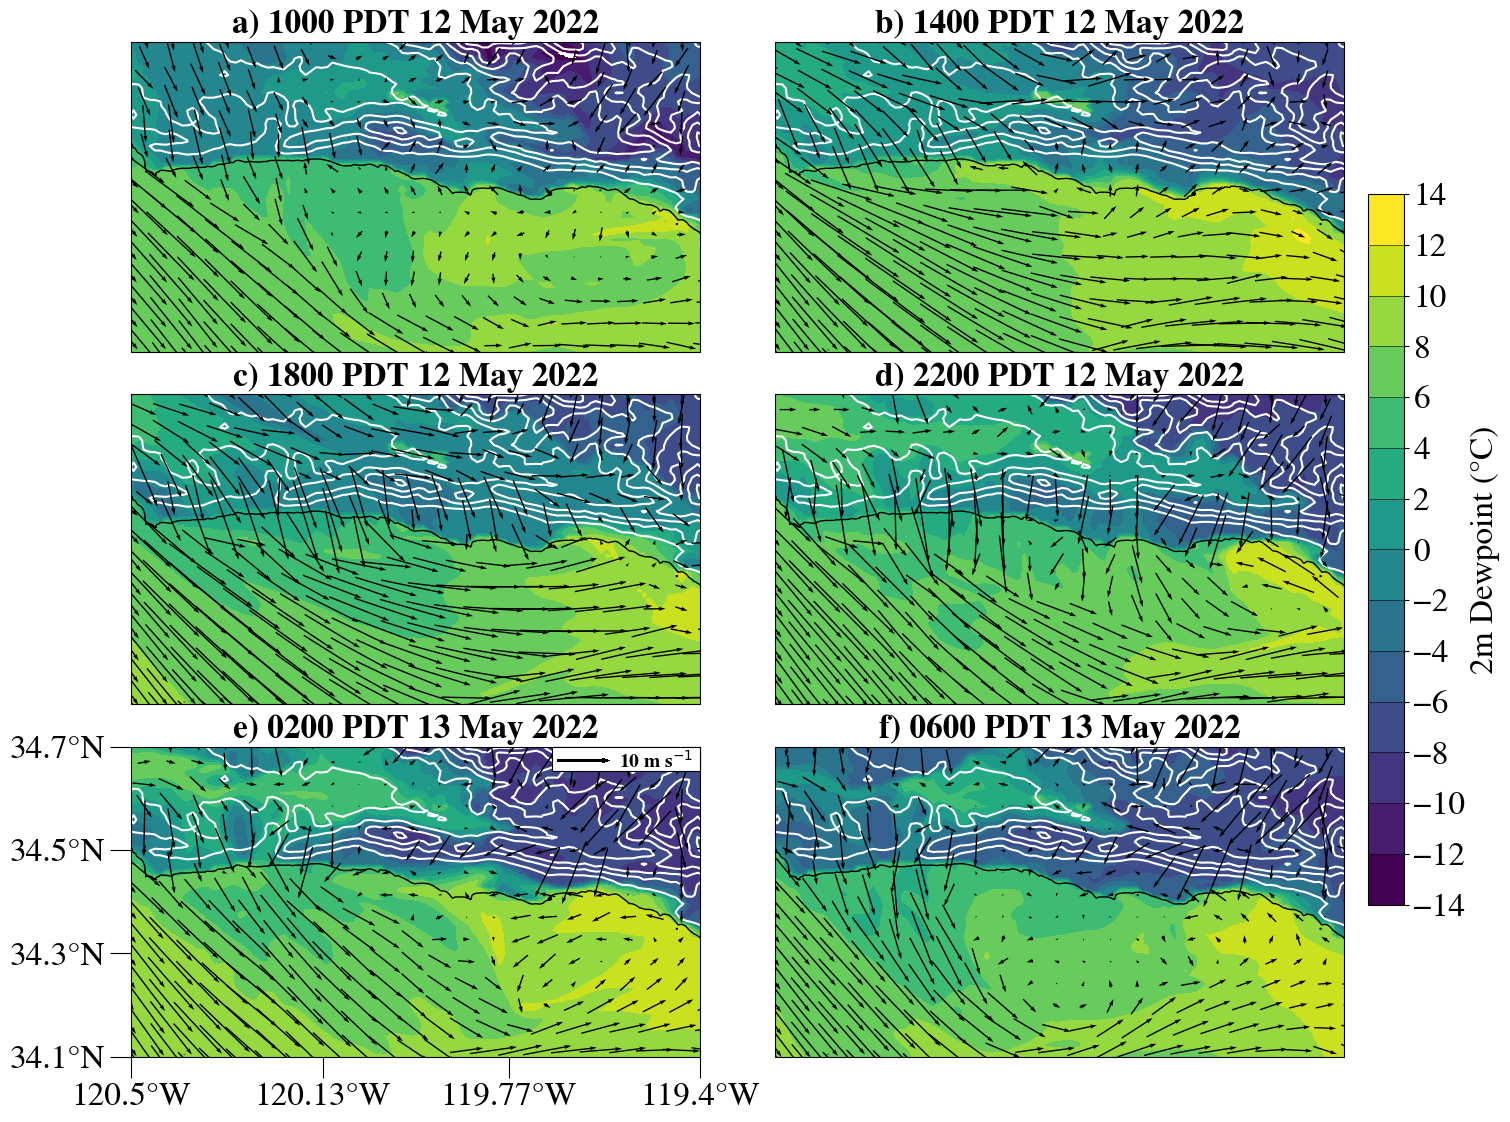

In [21]:
#-----------------------------------------------------
#Define wrf variable we want to plot with color
wrf_variable = dewp_2m_c

#Define cartopy plot domain in lat/lon coordinates
lon_lat_tick_num = [4, 4]
lon_lat_extent   = [-120.5, -119.4, 34.1, 34.7]
lon_lat_ticks    = [-120.5, -119.4, 34.1, 34.7]

#Define map and data coordinate reference system for our cartopy map
plot_crs = ccrs.PlateCarree()
data_crs = ccrs.PlateCarree()

#Define font properties for different items
fontdict_title_labels    = {'fontsize': 24, 'fontweight': 'bold',   'fontname': 'Nimbus Roman'}
fontdict_text_color_bar  = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_text_annotation = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_tick_labels     = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_quiver_key      = {'size': 14, 'weight': 'bold', 'family': 'Nimbus Roman'}
fontdict_legend_labels   = {'size': 16, 'weight': 'bold', 'family':'Nimbus Roman'}

#Define some levels for contourf
contourf_step = 2
contourf_min  = -14
contourf_max  = 14
contourf_levels = np.arange(contourf_min, contourf_max+contourf_step, contourf_step)

#Define cmap for contourf and colorbar and set out of bound values
contourf_cmap = plt.get_cmap('viridis').copy()

#Set the norm for contourf
contourf_norm = mcolors.BoundaryNorm(contourf_levels, ncolors=contourf_cmap.N, clip=False)

#Define a a list of datetimes that we want to plot
time_list = pd.to_datetime(['2022-05-12 17:00', '2022-05-12 21:00', '2022-05-13 01:00', '2022-05-13 05:00', '2022-05-13 09:00', '2022-05-13 13:00'])

#Define a list which will hold the letters that are used to title each subplot
subplot_letter_list = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

#Define a variable that indexes the times we want to iteratively plot for a specific variable
time_index_bool_array = wrf_variable.Time.isin(time_list)

#Draw cartopy basemap and return fig/axis
fig, axs = cartopy_basemap_subplots(plot_crs=plot_crs, data_crs=data_crs, 
                                    nrows=3, ncols=2, fig_size=(15,15), 
                                    wspace_float=None, hspace_float=None,
                                    lon_lat_extent=lon_lat_extent, 
                                    lon_lat_ticks=lon_lat_ticks, 
                                    lon_lat_tick_num=lon_lat_tick_num, 
                                    lon_lat_ticks_on=True, 
                                    xtick_ytick_set_list=[False, False, False, False, True, False],
                                    high_res_coastline=True, 
                                    high_res_wrf_topo_sb_bool=False, 
                                    low_res_wrf_topo_sb_bool=False, 
                                    low_res_wrf_topo_ca_bool=False, 
                                    wrf_topo_colorbar_each_plot_bool=False, 
                                    wrf_topo_colorbar_entire_figure_bool=False,
                                    scale_bar_bool=False, scale_bar_position=None, 
                                    inset_ca_bool=False, inset_bbox_position=None, 
                                    ocean_color='None')
#-----------------------------------------------------
#For every WRF timestep that is greater than or equal to a specific date, do the following:
for time_index_integer, (time_stamp, ax) in enumerate(zip(wrf_variable.Time[time_index_bool_array], axs.flatten())):
    
    #Plot wind for every n-th grid point
    nth_pt = 5
    
    #Plot quiver vectors for 10m wind
    quiver_plot = ax.quiver(wrf_variable.XLONG[::nth_pt, ::nth_pt], 
                            wrf_variable.XLAT[::nth_pt, ::nth_pt], 
                            u_wind_10m_ms.sel(Time=time_stamp)[::nth_pt, ::nth_pt], 
                            v_wind_10m_ms.sel(Time=time_stamp)[::nth_pt, ::nth_pt], 
                            angles='xy', scale_units='xy', pivot='middle',  
                            scale=100, zorder=10, transform=data_crs)
    
    #Plot filled contours showing 2m dewpoint
    contourf_plot = ax.contourf(dewp_2m_c.XLONG, 
                                dewp_2m_c.XLAT, 
                                dewp_2m_c.sel(Time=time_stamp), 
                                contourf_levels, cmap=contourf_cmap, norm=contourf_norm, transform=data_crs)
    
    #Plot contour lines for topography
    contour_levels = np.arange(250, 2250, 250)
    contour_plot   = ax.contour(wrf_variable.XLONG, 
                                wrf_variable.XLAT, 
                                terrain_height_m.sel(Time=time_stamp), 
                                colors='white', levels=contour_levels, transform=data_crs)
    
    #Add title with time/date information
    datetime_utc     = pd.to_datetime(time_stamp.values)
    datetime_pdt     = datetime_utc-pd.Timedelta(7, unit='h')
    datetime_pdt_str = f'{str(datetime_pdt.hour).zfill(2)}00 PDT {str(datetime_pdt.day).zfill(2)} May 2022'
    ax.set_title(f'{subplot_letter_list[time_index_integer]} {datetime_pdt_str}', **fontdict_title_labels)
        
    #Add stuff to specific subplot
    if time_index_integer == 4:

        #Define inset axis for quiver key
        ax1 = inset_axes(ax, width='100%',height='100%',loc='upper right', borderpad=0, bbox_to_anchor=(0.74, 0.92, 0.26, 0.08), bbox_transform=ax.transAxes)

        #Remove ticks from inset axis
        ax1.tick_params(labelleft=False,labelbottom=False,left=False,bottom=False)

        #Add quiver key to inset axis
        ax1.quiverkey(quiver_plot, X=0.84, Y=0.955, U=10, label=r'10 m s$^{-1}$', labelpos='E', fontproperties=fontdict_quiver_key)
#-----------------------------------------------------
#Colorbar for contourf
#https://matplotlib.org/3.1.1/gallery/axes_grid1/demo_colorbar_with_axes_divider.html
#Second Answer: https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
cbar = fig.colorbar(contourf_plot, ax=axs.ravel().tolist(), orientation='vertical', spacing='uniform', pad=0.02, fraction=0.03, shrink=0.7, drawedges=True, ticks=contourf_levels[::1])
cbar.set_label('2m Dewpoint (°C)', color='black', **fontdict_text_color_bar)

#Set font for colorbar tick lables
#https://stackoverflow.com/questions/7257372/set-font-properties-to-tick-labels-with-matplot-lib/7280803
ticks_font = matplotlib.font_manager.FontProperties(family='Nimbus Roman', style='normal', size=24, weight='normal', stretch='normal')
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(ticks_font)
#-----------------------------------------------------
#Save figure    
plt.savefig(f'./figures/figure_08_wrf_spatial.png', bbox_inches='tight', dpi=500)

#Show figure
plt.show()
#-----------------------------------------------------